### Gillespie algorithm for simulating kinesin walking on microtubules in vitro
MK Iwanski <br>
Universiteit Utrecht, Kaptein Lab <br>
2020-04-07

In [1]:
# imports
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
from scipy import ndimage
import os 
import datetime as dt
import cv2
#from skimage import img_as_ubyte
#from sklearn.neighbors import NearestNeighbors

In [2]:
# function for debugging
def pause():
    programPause = input('Press <ENTER> to continue.')

In [3]:
# parameters
mt_length = 100
nstep = 10**3
start_num_motors = 0

length_tubulin = 8 #nm

kin_vel = 2000 #nm/s
kin_land_rate = 0.2 #0.2 #/min /um /pM
kin_conc = 500 #pM in assay
kin_run_length = 1000 #nm

# options
zsave = True #save figs?

#rates of reactions
k_fwd = (kin_vel/length_tubulin)/1000 #steps per msec
k_bck = 0 #steps per msec
k_on = ((kin_land_rate*kin_conc/60)/(1000/length_tubulin))/1000 #per dimer per msec 
k_off = (kin_vel/kin_run_length)/1000 #per msec
#k_fwd = 1*10**(-6) #steps per usec
#k_bck = 0 #steps per usec
#k_on = 8*10**(-11) #per dimer per usec
#k_off = 5*10**(-8) #per usec

#update vectors for each reaction
nu_fwd = -1
nu_bck = -1
nu_on = 1
nu_off = -1

#update affinities of mt sites
alpha_max = 3*k_on # maximal change in k_on (at site of motor)       
decay_time = 100 # falls to 1/e in how much time [ms]
decay_dist = 1 # falls to 1/e in how many dimers [dimers]

In [4]:
print('k_fwd = {0:.7f} steps per msec'.format(k_fwd))
print('k_bck = {0:.7f} steps per msec'.format(k_bck))
print('k_on = {0:.7f} per dimer per msec'.format(k_on))
print('k_off = {0:.7f} per msec'.format(k_off))
#print('Please check that k_on and k_off are not identical!')

k_fwd = 0.2500000 steps per msec
k_bck = 0.0000000 steps per msec
k_on = 0.0000133 per dimer per msec
k_off = 0.0020000 per msec


In [5]:
def gillespie(X, t, k, nu): #update time and state vectors (mt and affinity)
#def gillespie(X,m,k,k_tot,nu):
    
    #generate random numbers
    #m = np.random.randint(0,mt_length) #for lattice site
    rt = np.random.random() #for time to next reaction
    rr = np.random.random() #for type of reaction
    
    k_tot = np.sum(k)
    
    #time to next reaction
    tau = np.log(1/rt)/k_tot
#    #We assume sum of k does not change significantly during this time step.
    
#    affinity[i+1,:] = affinity_update(affinity[i,:],X,(tau)) #future update of affinity
    
    
    m = np.random.randint(0,mt_length) #which lattice site to start with
    
    #determine which reaction
    j = 0
    test = k[0,m]/k_tot
    while test<rr: #and j<len(k[:,m])-1:  
        j += 1 
        
        if j >= len(k[:,m]): #if nothing happened at the present site, continue on to next site
            m += 1 
            if m >= mt_length: #if reached end of MT, start from beginning
                m = 0
            j = 0
            #test = 0 #k[0,m]/k_tot
           
        test += k[j,m]/k_tot
        

    #pause()

    t += tau #update time
    X[m] += nu[j] #update state

    if j == 0:
    #if k[j,m] == k_fwd:
        X[m+1] -= nu[j] #update state of +1 site for forward step
        #if m < mt_length-1 and X[m+1] == 0:
            #X[m+1] -= nu[j] #update state of +1 site for forward step
        #else: 
            #X[m] -= nu[j] #if it can't move forward, undo step forward 

    if j == 1:
    #if k[j,m] == k_bck:
        X[m-1] -= nu[j] #update state of -1 site for back step
        #if m >  0 and X[m-1] == 0:
             #X[m-1] -= nu[j] #update state of -1 site for back step
        #else: 
            #X[m] -= nu[j] #if it can't move backward, undo step backward 
    
    return X, t
    #return X

In [6]:
def find_closest_motor(lattice_site, motors):
    assert isinstance(lattice_site,int)
    
    motors = np.asarray(motors)
    idx = (np.abs(motors - lattice_site)).argmin()
    return motors[0,idx] 
    #pause()

In [7]:
def affinity_update(aff, X, t_step): #update affinity based on motor positions
    decay_aff = aff*np.exp(-t_step/decay_time) #affinities decay with time (back to baseline)
    
    motor_aff = np.zeros(aff.shape,dtype='float')
    motor_aff[:] = k_on
    motor_aff[X==1] = alpha_max #affinity at motor positions increase to max value

    motors = np.asarray(np.where(X==1), dtype=np.int)
    motors.flatten()
    #pause()
    if motors.size != 0:
        for j in range(0,mt_length):
            #for each lattice site, find closest motor
            closest_motor = find_closest_motor(j,motors)
            distance_from_site = int(np.abs(closest_motor-j))
            
            motor_aff[j] = alpha_max*np.exp(-distance_from_site/decay_dist) #update affinity based on closest motor

            
    new_aff = np.zeros(aff.shape,dtype='float')    
    for j in range(0,mt_length):
        if motor_aff[j] > decay_aff[j]:
            new_aff[j] = motor_aff[j]
        else:
            new_aff[j] = decay_aff[j]
    
    new_aff[new_aff<k_on] = k_on #set back to baseline if below
    new_aff[new_aff>alpha_max] = alpha_max #set back to max if above
    
    print('aff = {0}, decay_aff = {2}, motor_aff = {3}, new_aff = {1}'.format(aff,new_aff,decay_aff, motor_aff))
    pause()
    
    return new_aff

In [8]:
#initialize
mt = np.zeros((nstep,mt_length), dtype=np.int)
affinity = np.zeros((nstep,mt_length))
affinity[:] = k_on
t = np.zeros(nstep)

k = np.zeros((4,mt_length),dtype=np.float)
nu = [nu_fwd, nu_bck, nu_on, nu_off]

#place motor(s) on MT to begin
if start_num_motors != 0:
    for i in range(0,start_num_motors):
        mt[0,np.random.randint(0,mt_length)] = 1

In [ ]:
#run Gillespie
for i in range(0,nstep-1):
    
    #k = np.zeros((4,mt_length),dtype=np.float)
    
    #update reaction matrix 
    for j in range(0,mt_length):
        if mt[i,j] == 1: #site is occupied
            k[2,j] = 0
            k[3,j] = k_off
            if (j != mt_length-1 and mt[i,j+1] == 0): #site in front empty
                #k[:,j] = [k_fwd, k_bck, 0, k_off]
                #nu = [nu_fwd, nu_bck, 0, nu_off]
                k[0,j] = k_fwd
            else:
                k[0,j] = 0
            if (j != 0 and mt[i,j-1] == 0): #site behind empty
                #k[:,j] = [0, k_bck, 0, k_off]
                #nu = [0, nu_bck, 0, nu_off]
                k[1,j] = k_bck
            else:
                k[1,j] = 0
        else: #site is empty
            k[0,j] = 0
            k[1,j] = 0
            k[2,j] = affinity[i,j]
            k[3,j] = 0
    
    mt[i+1,:],t[i+1] = gillespie(mt[i,:],t[i],k,nu)

    affinity[i+1,:] = affinity_update(affinity[i,:],mt[i+1,:],(t[i+1]-t[i])) #future update of affinity
    
#pause() 

#print('The first time step was {0:.5f} sec'. format(t[1]/1000))
print('The average time step was {0:.5f} sec'. format(np.mean(np.diff(t))/1000))
#print('The average time step with ~no motors should be {0:.5f} sec'. format((1/(np.sum(k)))/1000))
print('The total time was {0:.5f} min'. format((t[-1]/60)/1000))

aff = [1.33333333e-05 1.33333333e-05 1.33333333e-05 1.33333333e-05
 1.33333333e-05 1.33333333e-05 1.33333333e-05 1.33333333e-05
 1.33333333e-05 1.33333333e-05 1.33333333e-05 1.33333333e-05
 1.33333333e-05 1.33333333e-05 1.33333333e-05 1.33333333e-05
 1.33333333e-05 1.33333333e-05 1.33333333e-05 1.33333333e-05
 1.33333333e-05 1.33333333e-05 1.33333333e-05 1.33333333e-05
 1.33333333e-05 1.33333333e-05 1.33333333e-05 1.33333333e-05
 1.33333333e-05 1.33333333e-05 1.33333333e-05 1.33333333e-05
 1.33333333e-05 1.33333333e-05 1.33333333e-05 1.33333333e-05
 1.33333333e-05 1.33333333e-05 1.33333333e-05 1.33333333e-05
 1.33333333e-05 1.33333333e-05 1.33333333e-05 1.33333333e-05
 1.33333333e-05 1.33333333e-05 1.33333333e-05 1.33333333e-05
 1.33333333e-05 1.33333333e-05 1.33333333e-05 1.33333333e-05
 1.33333333e-05 1.33333333e-05 1.33333333e-05 1.33333333e-05
 1.33333333e-05 1.33333333e-05 1.33333333e-05 1.33333333e-05
 1.33333333e-05 1.33333333e-05 1.33333333e-05 1.33333333e-05
 1.33333333e-05 1.

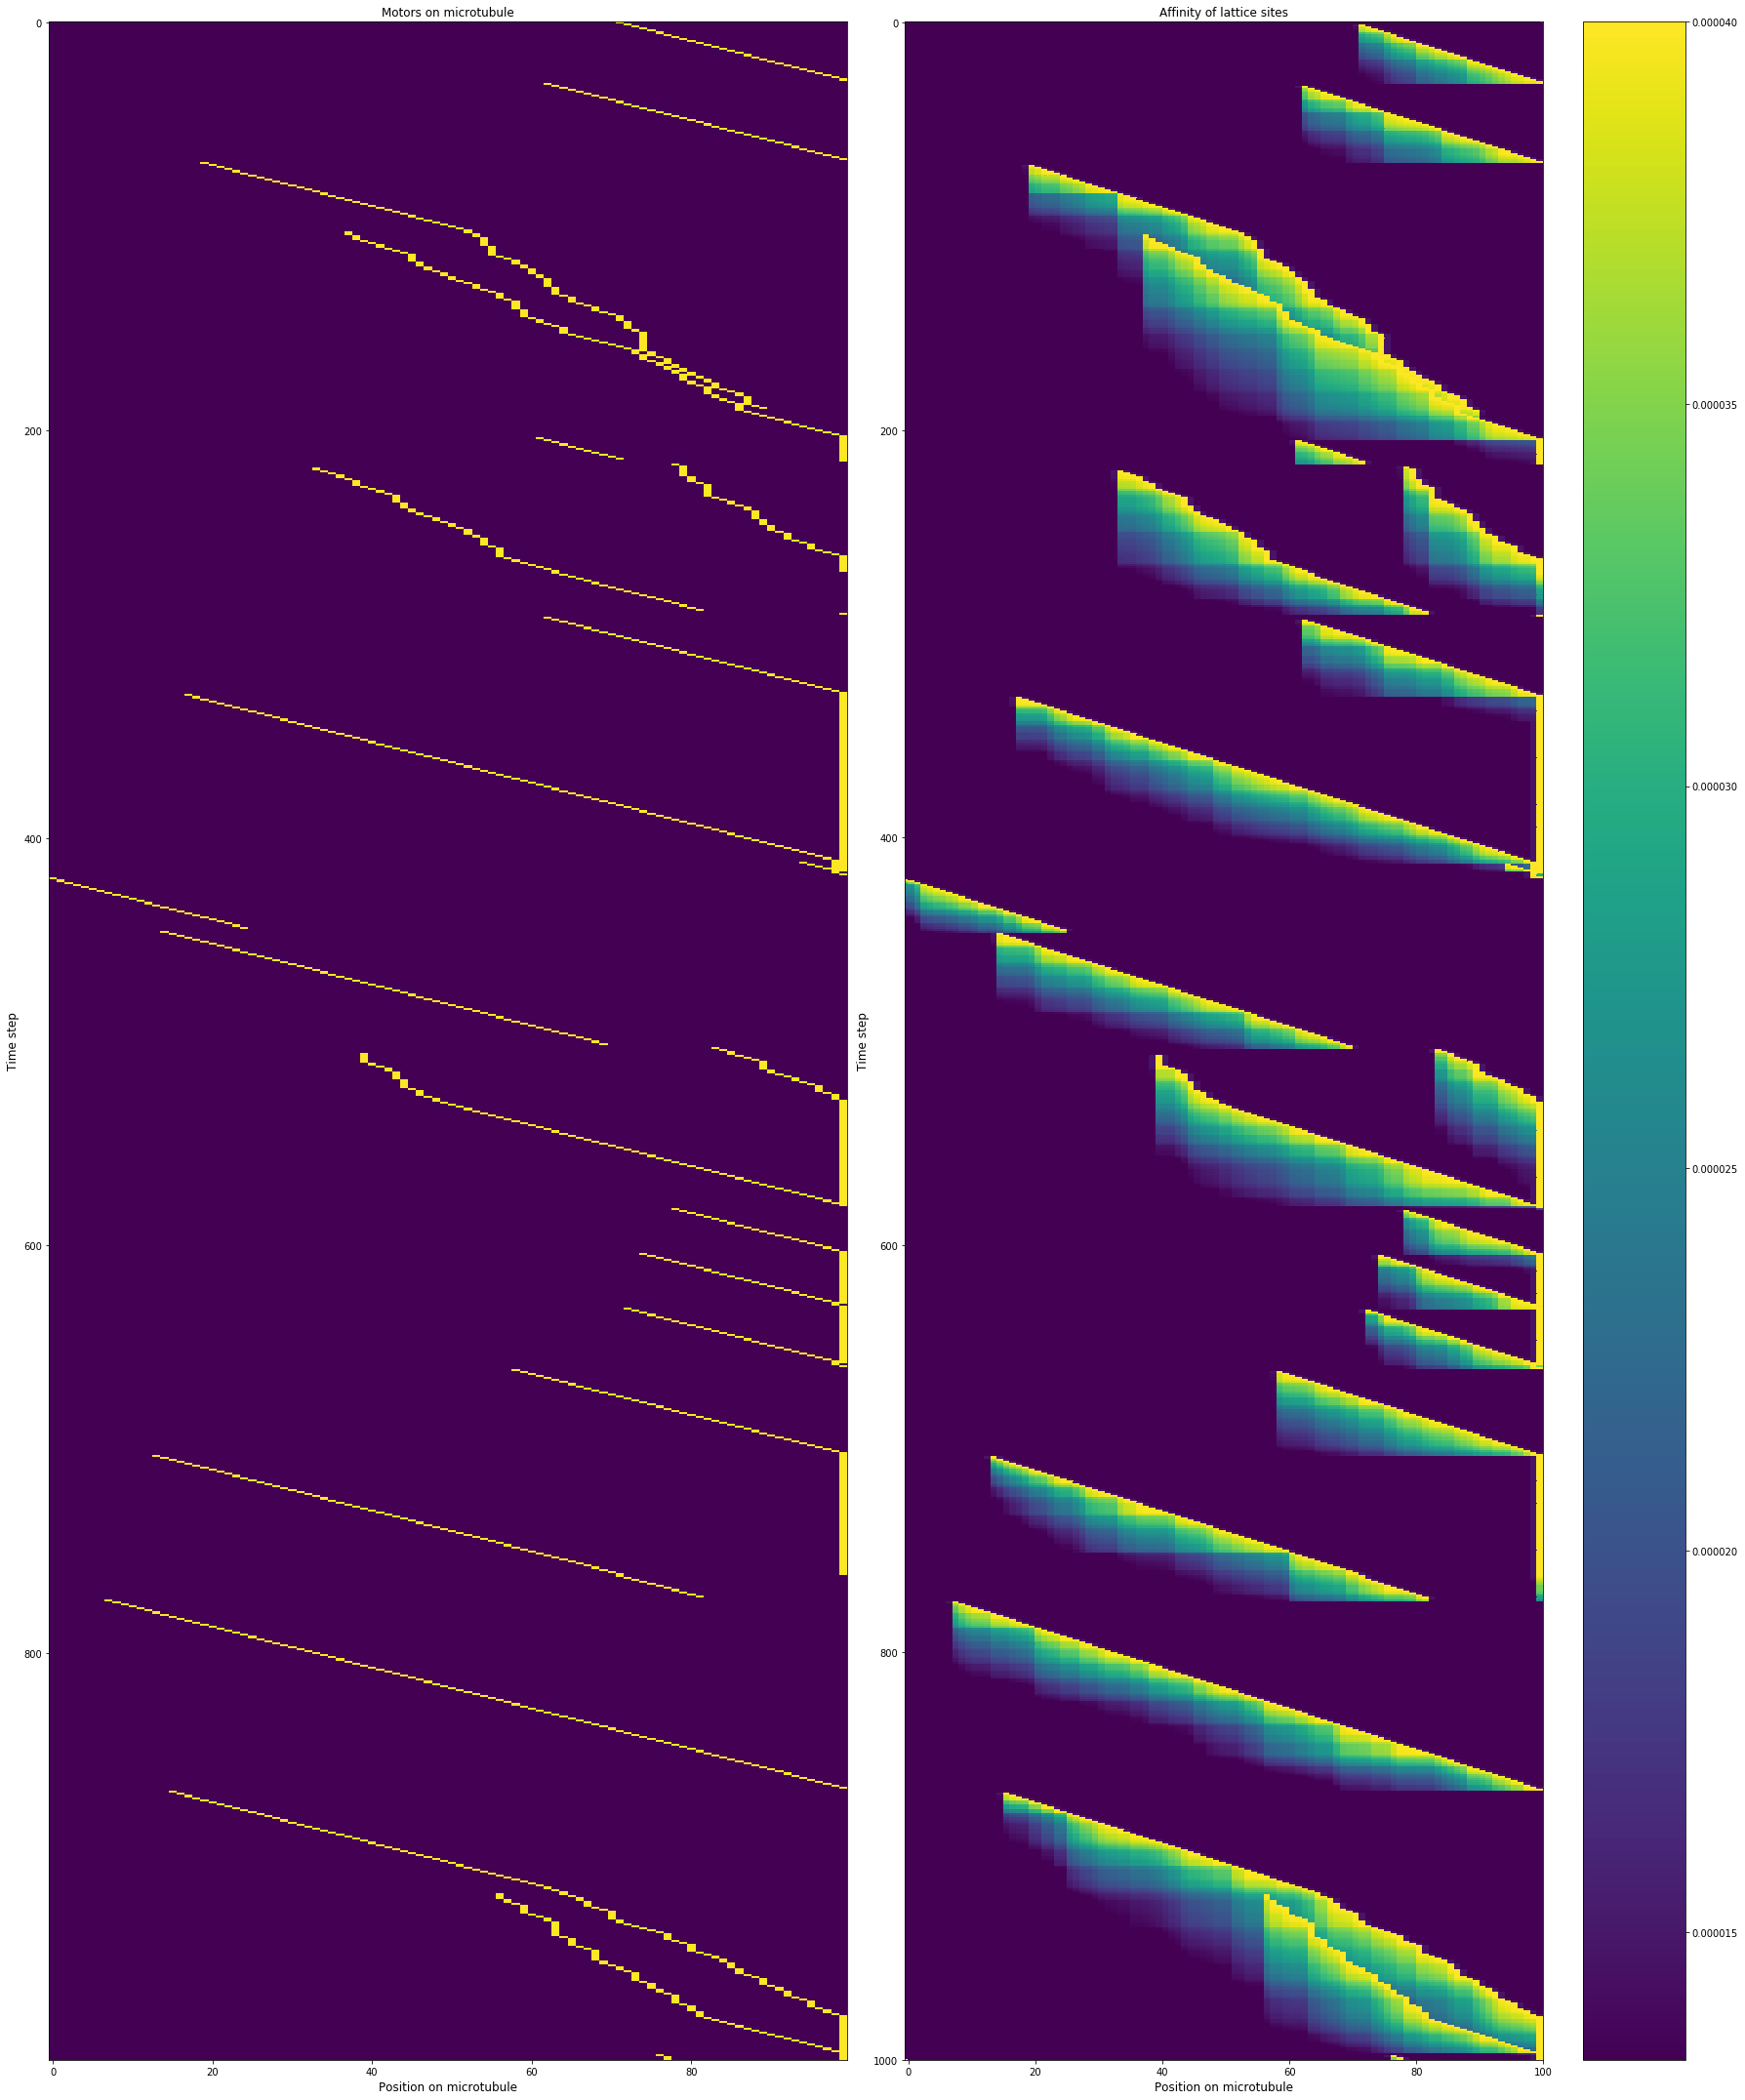

In [47]:
# plot results
%matplotlib inline
fig, ax = plt.subplots(1,2, figsize=(25, 30)) #25x100 for 10^5 steps, 25x300 for 10^4 steps

ax[0].imshow(mt, cmap='viridis', aspect='auto', interpolation='nearest',clim=(k_on,alpha_max))
ax[0].set_title("Motors on microtubule", fontsize=12)
ax[0].set_ylabel("Time step", fontsize=12)
ax[0].set_xlabel("Position on microtubule", fontsize=12)
#pcm = ax[1].pcolormesh(mt,norm = mpl.colors.Normalize(vmin=k_on,vmax=alpha_max),cmap='viridis')

ax[1].imshow(affinity, cmap='viridis', aspect='auto', interpolation='nearest',clim=(k_on,alpha_max))
ax[1].set_title("Affinity of lattice sites", fontsize=12)
ax[1].set_ylabel("Time step", fontsize=12)
ax[1].set_xlabel("Position on microtubule", fontsize=12)
pcm = ax[1].pcolormesh(affinity,norm = mpl.colors.Normalize(vmin=k_on,vmax=alpha_max),cmap='viridis')
fig.colorbar(pcm, ax=ax[1])

plt.tight_layout()

# save fig
if zsave == True:
    script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(script_dir, 'Results/')
    file_name = 'Simulation_{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)
    plt.savefig(results_dir + file_name,dpi=130)

plt.show()

In [33]:
#reformat to create an image from each time point
mt_as_stack = np.reshape(mt,(mt.shape[0],mt.shape[1],1))
mt_as_stack = np.moveaxis(mt_as_stack,1,-1) #t,y,x

padded_height = 7 #ideally an odd number
zero_row = np.zeros((1,mt.shape[1]),dtype=float)
mid_row = int(np.floor(padded_height/2))
padded_stack = np.zeros((mt.shape[0],padded_height,mt.shape[1]),dtype=float)

for i in range(mt.shape[0]):
    padded_stack[i,mid_row,:]=mt[i,]
    padded_stack[i,]=ndimage.gaussian_filter(padded_stack[i,], sigma=1)
    
padded_stack = padded_stack.astype(np.float64) / np.amax(padded_stack) # normalize the data to 0 - 1
padded_stack = 255 * padded_stack # scale by 255


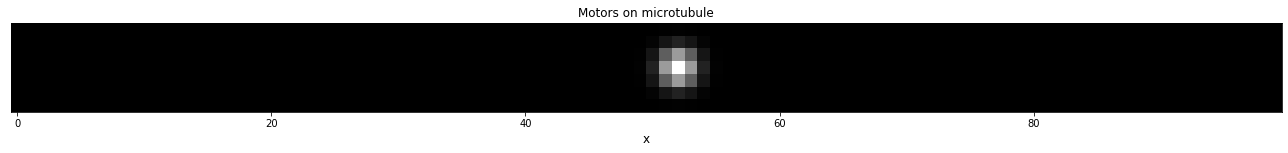

In [35]:
#check reformatting is working by plotting a random frame
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(18, 2))

ax.imshow(padded_stack[np.random.randint(0,nstep),], cmap='gray', interpolation='nearest')
ax.set_title("Motors on microtubule", fontsize=12)
ax.axes.get_yaxis().set_visible(False)
ax.set_xlabel("x", fontsize=12)

plt.tight_layout()
plt.show()

In [36]:
#save a movie of the simulation
if zsave == True:
    fps = 1000
    img_array = []

    script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(script_dir, 'Results/')
    file_name = 'Simulation_movie_{}.avi'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)

    for i in range(mt.shape[0]):
        img = padded_stack[i,].astype(np.uint8)
        height, width = img.shape
        size = (width,height)
        img_array.append(img)

    out = cv2.VideoWriter(results_dir + file_name,cv2.VideoWriter_fourcc(*'M','J','P','G'), fps, size, False) #'DIVX'

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

### TO DO:
* Adjust parameters to make physiological
* Fix affinity decay with time
* Run simulation with time steps as above, but sample at 100ms frame rate
* Currently updating affinity for the future based on past time step
* If forward step chosen, but motor can't move forward, should I keep motor in place?
* Should motor move more than one dimer if time duration is long?